# Notæ 7

# Incidencia de cotas duales en la resolución de PLE

## Introducción

En esta nota vamos a estudiar técnicas para mejorar la optimización de la resolución de Programas
Lineales Enteros. Como sabemos, la optimización alcanza su fin cuando convergen la cota primal (aquella que
surge de la obtención de una solución entera factible del problema) y la cota dual (aquella dada por la peor
relajación entre los actuales nodos hoja evaluados del árbol B&B (banch-and-bound)).

Por ejemplo, si en nuestro problema, resulta sencillo elevar la cota dual pero es difícil encontrar soluciones factibles,
una posible solución es barrer el árbol B&B enfatizando en la búsqueda de soluciones, es decir que su recorrido sea de tipo
primero-profundo. Así CPLEX va a priorizar profundizar en el árbol hasta encontrar soluciones enteras. El caso inverso es
querer enfatizar en la mejora de la cota dual, aquí CPLEX va a priorizar evaluar aquellos nodos cuya relajación lineal sea
la que está imponiendo la actual cota dual. Su recorrido se asemeja a una búsqueda a lo ancho.
La estrategia actual de CPLEX es balancear ambos aspectos, pero cuenta con parámetros para que el usuario pueda elegir.

Pero además de la forma de explorar el árbol B&B, tenemos herramientas para atacar ambas cotas, que son:
- Heurísticas primales: consisten en aprovechar la solución fraccionaria de un nodo para fabricar una solución entera; esto
evita que CPLEX tenga que profundizar en el árbol para alcanzarla, dejando nodos abiertos innecesariamente.
- Rutinas de separación de desigualdades válidas: consisten en aprovechar la solución fraccionaria de un nodo para generar
desigualdades que la corten y así elevar el resultado de la relajación lineal, que impactará en la cota dual.

Vamos a seguir como caso de estudio al Problema de Coloreo de Grafos clásico (PCG) formulado mediante variables de asignación vértice-color. En esta formulación, las variables $x_{vk}$ son binarias y valen 1 cuando al vértice $v$ se le asigna el color $k$.
Las variables $w_k$ también son binarias y valen 1 cuando el color $k$ es utilizado por algún vértice.

\begin{align*}
\text{Minimizar:} & \sum_{k \in \mathcal C}w_k \tag{COL} \\
\text{Sujeto a:} & \sum_{k \in \mathcal C} x_{vk} = 1 & \forall~v \in V. \tag{1}\\
& x_{vk} + x_{uk} \leq w_k & \forall~vu \in E,~  k \in \mathcal C. \tag{2} \\
& \sum_{v \in V} x_{vk} \geq w_k & \forall~k \in \mathcal C. \tag{3} \\ 
& w_k \in \{0,1\} & \forall~k \in \mathcal C.\\
& x_{vk} \in \{0,1\} & \forall~v \in V,~k \in \mathcal C.
\end{align*}

No obstante, las restricciones $(3)$ pueden omitirse ya que se satisfacen naturalmente en la solución óptima (probar en Actividad 1).

### Repaso: Resolverlo con CPLEX

Comenzando importanto los paquetes necesarios.

In [1]:
from docplex.mp.model import Model
import networkx as nx

Ahora, vamos a implementar las funciones necesarias para construir el modelo basado en la formulación (COL) y resolverlo. Estas funciones no son nuevas y ya fueron explicadas en detalle en los notebook anteriores.

In [2]:
def max_grado(G):
    grados = [G.degree(v) for v in G]
    return max(grados)

def construir_modelo_col(G, C):
    """Construye un modelo de PLE para el PCV."""
    
    modelo = Model(name='col') # Inicializamos el modelo 
    
    # Variables
    X = [[modelo.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in G]
    W = [modelo.binary_var(name='w_' + str(k)) for k in C]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(W[k] for k in C))
    
    # Restricciones (1)
    for v in G:
        modelo.add_constraint(modelo.sum(X[v][k] for k in C) == 1)
    # Restricciones (2)
    for u, v in G.edges:
        for k in C:
            modelo.add_constraint(X[u][k] + X[v][k] <= W[k])    
    
    return modelo

def resolver(modelo, archivo=True):
    
    # Resolvemos el modelo
    sol = modelo.solve(log_output=archivo)
 
    # Retornamos la solucion
    return sol

A continuación, vemos un ejemplo de ejecución sobre un grafo rueda de 5 vértices $G = W_5$.

In [3]:
G = nx.wheel_graph(5)
C = range(0,max_grado(G) + 1)
modelo = construir_modelo_col(G, C)
sol = resolver(modelo)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 20 rows and 0 columns.
MIP Presolve modified 20 coefficients.
Reduced MIP has 25 rows, 30 columns, and 105 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.07 ticks)
Found incumbent of value 5.000000 after 0.02 sec. (0.16 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 25 rows, 30 columns, and 105 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.12 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Clique table members: 25.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.05 ticks)

        Nodes                                         

Mediante la cual se obtiene la siguiente solución óptima, con valor objetivo igual a 3.

In [4]:
sol.display()

solution for: col
objective: 3
status: OPTIMAL_SOLUTION(2)
x_0_3 = 1
x_1_4 = 1
x_2_1 = 1
x_3_4 = 1
x_4_1 = 1
w_1 = 1
w_3 = 1
w_4 = 1


### &#x1f4bb; Actividad 1

- Explique qué tipo de soluciones enteras elimina la restricción (COL.3). De un ejemplo, tomando como grafo la rueda de grado 5.
- Genere un grafo aleatorio de 20, otro de 25 y otro de 30 vértices, con 50% de densidad de aristas. Utilice la formulación anterior para resolverlo. Luego repítalo, pero añadiendo la restricción (COL.3). ¿Ve alguna mejora en el tiempo de resolución?  

## Relajación lineal

Empecemos por observar cómo resolver la relajación lineal de una formulación PLE, lo cual es muy sencillo gracias a DOcplex. La siguiente función, <code>relajacion_lineal</code>, toma un modelo de PLE y retorna un modelo de PL con su relajación lineal. En su definición, se hace uso del método <code>make_relaxed_model</code> de la clase <code>LinearRelaxer</code>.

In [5]:
from docplex.mp.relax_linear import LinearRelaxer

def relajacion_lineal(modelo):
    return LinearRelaxer.make_relaxed_model(modelo)

Y veamos un ejemplo de cómo usar esta función. El modelo de PL se resuelve de la misma forma que un modelo de PLE, es decir, mediante el método <code>solve</code>, por lo tanto, podemos aprovechar la función <code>resolver</code> que definimos más arriba.

In [6]:
relajacion = relajacion_lineal(modelo)
sol = resolver(relajacion)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 45 rows, 30 columns, and 145 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Symmetry aggregator did 68 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixing 9 variables.
        8 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Dual:  Pushed 3, exchanged 6.
  Primal:  Fixing 4 variables.
        3 PMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 PMoves:  Infeasibility  2.22044605e-16  Objective  2.00000000e+00
  Primal:  Pushed 3, exchanged 1.


Se obtiene la siguiente solución óptima, con valor objetivo igual a 2 (menor al de la solución óptima entera).

In [7]:
sol.display()

solution for: lp_col
objective: 2.000
status: OPTIMAL_SOLUTION(2)
x_0_0 = 0.500
x_0_3 = 0.500
x_1_0 = 0.500
x_1_3 = 0.500
x_2_0 = 0.500
x_2_3 = 0.500
x_3_0 = 0.500
x_3_3 = 0.500
x_4_0 = 0.500
x_4_3 = 0.500
w_0 = 1.000
w_3 = 1.000


## Desigualdades válidas

Vamos a comenzar proponiendo potenciales desigualdades válidas para (COL) que permitan ajustar su relajación
lineal. Estamos interesados en hallar desigualdades válidas que, por un lado, sean violadas por soluciones fraccionarias como la mostrada más arriba, y por el otro lado, que al incorporarlas en la formulación, logren elevar el valor objetivo lo <i>más posible</i>. 

Veamos un ejemplo. Consideremos el grafo rueda de 5 vértices, G = $W_5$, definido anteriormente.

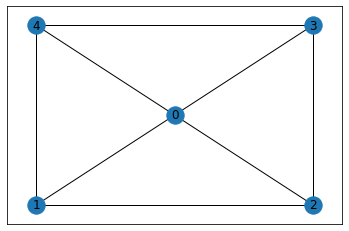

In [8]:
nx.draw_networkx(G, pos={0: (1,1), 1: (0,0), 2: (2,0), 3: (2,2), 4: (0,2)})

Sabemos que, por ejemplo, los vértices 0, 1 y 2 forman una clique. Por lo tanto, para todo color $k$, todo coloreo verifica que a lo sumo un vértice de {0,1,2} se pinta con $k$. Es decir, tenemos las siguientes desigualdades válidas:

$$ x_{0k} + x_{1k} + x_{2k} \leq w_k,~~~~~~ \forall~ k \in \mathcal C $$

Es crucial notar que, por el contrario, no toda solución fraccionaria (i.e. solución factible de la relajación lineal) las verifica. Por ejemplo, la solución óptima fraccionaria encontrada anteriormente la viola para $k=0$, pues $$x_{00}+x_{10}+x_{20} = 1,5 \not\leq 1 = w_0.$$ 
Verifiquemos esta última cuenta:

In [9]:
print("Lado izquierdo: ", sol.get_value("x_0_0") + sol.get_value("x_1_0") + sol.get_value("x_2_0"))
print("Lado derecho: ", sol.get_value("w_0"))

Lado izquierdo:  1.5
Lado derecho:  1.0


¡Esta desigualdad válida que encontramos podemos usarla para ajustar nuestro poliedro! Es decir, agregando esta restricción a la formulación cortamos la solución fraccionaria que encontramos anteriormente. ¡Hagámoslo!

En este punto, nos encontramos con una pequeña sutileza, fácilmente subsanable, pero que vale la pena mencionar. Ya conocemos el método <code>add_constraint</code> de la clase <code>Model</code>, usada para agregar restricciones en un modelo (por ejemplo, ver cómo la llamamos en la función <code>construir_modelo_col</code> definida al comienzo del notebook). Este método necesita acceder a las variables del modelo para poder construir la restricción deseada. Sin embargo, en nuestra implementación, las variables fueron guardadas en las variables de Python <code>X</code> y <code>W</code> en la función <code>construir_modelo_col</code>, las cuales son locales, es decir, no podemos llamarlas fuera del alcance de la definición de esta función. 

Por lo tanto, tenemos varias opciones. La primera, es definir una nueva función <code>construir_modelo_col_ajustado</code>, la cual hace lo mismo que <code>construir_modelo_col</code>, salvo que al final agrega la desigualdad válida deseada. Si bien esto nos soluciona el problema, no es una buena práctica de programación en general, dado que tendríamos mucha repetición de código. 

Otra opción, es modificar <code>construir_modelo_col</code> para que las variables <code>X</code> y <code>W</code> sean globales, y puedan ser usadas fuera del alcance de la definición de la función. En general, esto tampoco es recomendable, en particular cuando se trabaja con varios modelos a la vez, dado que coexistirían muchas variables y sería propenso a errores.

La opción elegida, mucho más recomendable, no modifica el código que ya hicimos, sino que lo aprovecha y lo complementa con una nueva función <code>recuperar_variables</code>, que toma un modelo de (COL) y retorna sus variables. Esto es posible gracias al método <code>get_var_by_name</code> de la clase <code>Model</code> que permite buscar una variable por su nombre.

In [10]:
def recuperar_variables(G, C, modelo):
    X = [[modelo.get_var_by_name("x_" + str(v) + "_" + str(k)) for k in C] for v in G]
    W = [modelo.get_var_by_name("w_" + str(k)) for k in C]
    return X, W

Ahora si, procedemos a construir un nuevo modelo llamando a la función <code>construir_modelo_col</code>, luego recuperamos sus variables llamando a <code>recuperar_variables</code> y finalmente agregamos con el método <code>add_constraint</code> la desigualdad válida deseada, en este caso, $x_{00}+x_{10}+x_{20} \leq w_0.$

In [11]:
modelo_ajustado = construir_modelo_col(G, C)
X, W = recuperar_variables(G, C, modelo_ajustado)
modelo_ajustado.add_constraint(X[0][0] + X[1][0] + X[2][0] <= W[0])

docplex.mp.LinearConstraint[](x_0_0+x_1_0+x_2_0,LE,w_0)

Ahora, resolvamos la relajación lineal.

In [12]:
relajacion_ajustada = relajacion_lineal(modelo_ajustado)
sol = resolver(relajacion_ajustada)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 46 rows, 30 columns, and 149 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Symmetry aggregator did 54 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000

Dual crossover.
  Dual:  Fixing 4 variables.
        3 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Dual:  Pushed 1, exchanged 3.
  Primal:  Fixing 3 variables.
        2 PMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 PMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Primal:  Pushed 2, exchanged 1.


Y veamos su solución óptima.

In [13]:
sol.display()

solution for: lp_col
objective: 2.000
status: OPTIMAL_SOLUTION(2)
x_0_1 = 0.500
x_0_3 = 0.500
x_1_1 = 0.500
x_1_3 = 0.500
x_2_1 = 0.500
x_2_3 = 0.500
x_3_1 = 0.500
x_3_3 = 0.500
x_4_1 = 0.500
x_4_3 = 0.500
w_1 = 1.000
w_3 = 1.000


Obviamente, obtuvimos una solución distinta, sin embargo no aumentó la cota dual. ¿Por qué? &#x1f914;

Lo que pasó es que nos dio una solución simétrica, apagó el color 0 y encendió el 1. Ok, entonces agreguemos estas desigualdades válidas para todos los colores.

In [14]:
modelo_ajustado = construir_modelo_col(G, C)
X, W = recuperar_variables(G, C, modelo_ajustado)
for k in C:
    modelo_ajustado.add_constraint(X[0][k] + X[1][k] + X[2][k] <= W[k])
relajacion_ajustada = relajacion_lineal(modelo_ajustado)
sol = resolver(relajacion_ajustada)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 50 rows, 30 columns, and 165 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Symmetry aggregator did 67 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixing 20 variables.
       19 PMoves:  Infeasibility  0.00000000e+00  Objective  3.00000000e+00
        0 PMoves:  Infeasibility  0.00000000e+00  Objective  3.00000000e+00
  Primal:  Pushed 8, exchanged 12.


Veamos la solución óptima.

In [15]:
sol.display()

solution for: lp_col
objective: 3.000
status: OPTIMAL_SOLUTION(2)
x_0_0 = 0.250
x_0_2 = 0.125
x_0_3 = 0.250
x_0_4 = 0.375
x_1_0 = 0.250
x_1_1 = 0.250
x_1_3 = 0.250
x_1_4 = 0.250
x_2_0 = 0.500
x_2_2 = 0.125
x_2_4 = 0.375
x_3_0 = 0.250
x_3_2 = 0.125
x_3_4 = 0.625
x_4_0 = 0.750
x_4_3 = 0.250
w_0 = 1.000
w_1 = 0.250
w_2 = 0.250
w_3 = 0.500
w_4 = 1.000


¡Éxito! No solo cortamos la solución fraccionaria anterior (y sus soluciones simétricas), sino que además pudimos elevar el valor óptimo de la relajación lineal, pasó de 2 a 3.

Aunque el trabajo que hicimos fue específico al grafo rueda $W_5$, este tipo de desigualdades válidas se pueden aplicar a cualquier grafo y clique. Estudiemos cómo se formaliza.

### Restricciones clique

<b>Proposición.</b> Considerar el modelo (COL) para una instancia del PCG formada por un grafo $G=(V,E)$ y un conjunto de colores $\mathcal C$. Para toda clique $Q \subset V$ y color $k \in \mathcal C$, la siguiente restricción es una desigualdad válida

$$\sum_{v \in Q}x_{vk} \leq w_k,$$

y se conoce como <b>restricción clique</b>.

<b>Observación 1.</b> Las restricciones $(COL.2)$ son restricciones clique asociadas a cliques de cardinal 2 (los extremos de la arista), y en general no son maximales.

<b>Observación 2.</b> En particular, siendos dos cliques $Q' \subset Q$, la restricción clique asociada a $Q$ domina a la asociada a $Q'$, pues 

$$\sum_{v \in Q'}x_{vk} \leq \sum_{v \in Q}x_{vk} \leq w_k.$$ 

Por lo tanto, basta con considerar cliques maximales. Llamaremos $\mathcal Q$ al conjunto de cliques maximales del grafo.

## Incorporación de desigualdades válidas

Desde lo algorítmico, existen dos estrategias principales para incorporar desigualdades válidas.

1. Agregarlas como restricciones en la formulación y resolver la formulación resultante. Es decir, todas las desigualdades válidas estarán desde el comienzo en todos los nodos del árbol de B\&B. Esta estrategia fue la que usamos en el ejemplo del grafo rueda $W_5$. 

2. Comenzar con la formulación original e ir agregando las desigualdades válidas bajo demanda a medida que se necesiten. Es decir, en cada nodo del árbol de B\&B, se agregan únicamente las desigualdades válidas que estén siendo violadas, dando como resultado un algoritmo de tipo B\&C (banch-and-cut).

### Desigualdades válidas en la formulación

Continuemos viendo algunos ejemplos adicionales para esta estrategia. Vamos a agregar a la formulación (COL) todas las restricciones cliques asociadas a $\mathcal Q$. Es decir, ahora nuestra formulación de PLE es la siguiente.

\begin{align*}
\text{Minimizar:} & \sum_{k \in \mathcal C}w_k \tag{CLI} \\
\text{Sujeto a:} & \sum_{k \in \mathcal C} x_{vk} = 1 & \forall~v \in V. \tag{1}\\
& x_{vk} + x_{uk} \leq w_k & \forall~vu \in E,~  k \in \mathcal C. \tag{2} \\
& \sum_{v \in Q} x_{vk} \leq w_k & \forall~Q \in \mathcal Q,~  k \in \mathcal C. \tag{3} \\
& w_k \in \{0,1\} & \forall~k \in \mathcal C.\\
& x_{vk} \in \{0,1\} & \forall~v \in V,~k \in \mathcal C.
\end{align*}

<b>Observación.</b> Las restricciones $(2)$ quedan implicadas por las $(3)$, luego podemos sacarlas de la formulación sin perder soluciones factibles. Para no complicar las cosas, las dejaremos y confiaremos en el poder de CPLEX para detectar y eliminar restricciones redundantes.

A continuación, definimos una función <code>construir_modelo_cli</code> que construye un modelo para esta formulación de PLE.

In [16]:
def construir_modelo_cli(G, C):
    modelo = construir_modelo_col(G, C)
    modelo.name = "cli"
    X, W = recuperar_variables(G, C, modelo)
    for Q in nx.find_cliques(G):
        for k in C:
            modelo.add_constraint(modelo.sum(X[v][k] for v in Q) <= W[k])
    return modelo

¿Cómo se comportará esta formulación? ¿Mejor o peor que (COL)? &#x1f914;

Haremos algunas pruebas computacionales para intentar responder estas preguntas. Trabajaremos con un grafo aleatorio con $n=30$ y $p=0.35$. Usaremos la semilla <code>seed=0</code> para trabajar todos/as con el mismo grafo.

In [17]:
G = nx.erdos_renyi_graph(30, 0.35, seed=0)
C = range(max_grado(G)+1)
modelo_col = construir_modelo_col(G, C)
modelo_cli = construir_modelo_cli(G, C)

Primero, veamos la performance de resolver sus relajaciones lineales. Para la relajación lineal de (COL) tenemos:

In [18]:
relajacion_col = relajacion_lineal(modelo_col)
resolver(relajacion_col)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 2175 rows, 465 columns, and 6885 nonzeros.
Presolve time = 0.00 sec. (1.81 ticks)
Symmetry aggregator did 2436 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixing 2 variables.
        1 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Dual:  Pushed 0, exchanged 2.
  Primal:  Fixing 14 variables.
       13 PMoves:  Infeasibility  8.32667268e-17  Objective  2.00000000e+00
        0 PMoves:  Infeasibility  3.05311332e-16  Objective  2.00000000e+00
  Primal:  Pushed 13, exchanged 1.


docplex.mp.solution.SolveSolution(obj=2,values={x_0_0:0.5,x_0_8:0.5,x_1_..

Y para la relajación lineal de (CLI):

In [19]:
relajacion_cli = relajacion_lineal(modelo_cli)
resolver(relajacion_cli)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 4 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 3 threads...
Tried aggregator 1 time.
LP Presolve eliminated 135 rows and 0 columns.
Reduced LP has 3375 rows, 465 columns, and 12030 nonzeros.
Presolve time = 0.01 sec. (3.04 ticks)
Symmetry aggregator did 3556 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             4.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixing 182 variables.
      181 PMoves:  Infeasibility  2.77555756e-17  Objective  4.00000000e+00
       41 PMoves:  Infeasibility  2.16077156e-14  Objective  4.00000000e+00
        0 PMoves:  Infeasibility  4.96456900e-13  Objective  4.00000000e+00
  Primal:  Pushed 33, exchanged 149.

Dual simplex solved model.



docplex.mp.solution.SolveSolution(obj=4,values={x_0_4:0.0895522,x_0_6:0...

Hagamos un resumen de estos resultados y comparemos la perfomance:

In [20]:
def imprimir_resumen(modelo):
    print(modelo.name, ":")
    print("\tNúmero de restricciones: ", modelo.number_of_constraints)
    print("\tTiempo: ", modelo.solve_details.time, " s")
    print("\tValor objetivo: ", modelo.objective_value)
    print("\tNúmero de nodos: ", modelo.solve_details.nb_nodes_processed)
    
imprimir_resumen(relajacion_col)
imprimir_resumen(relajacion_cli)

lp_col :
	Número de restricciones:  2175
	Tiempo:  0.027004003524780273  s
	Valor objetivo:  2.0
	Número de nodos:  0
lp_cli :
	Número de restricciones:  3510
	Tiempo:  0.0722508430480957  s
	Valor objetivo:  3.9999999999999996
	Número de nodos:  0


La relajación lineal de (COL) tiene menos restricciones y su resolución es más rápida, pero la cota inferior que aporta es bastante débil. Por el contrario, la relajación lineal de (CLI) presenta una marcada mejora en el valor objetivo, aunque posee más restricciones y su resolución demora más tiempo.

Con este análisis solo estamos evaluando lo que sucede en el nodo raíz del árbol de B\&B. ¿Qué pasará cuando consideremos el árbol completo? La intuición nos dice que comenzar con una relajación más ajustada hace que CPLEX pueda podar nodos con mayor rapidez y cerrar el gap anticipadamente, pero a su vez cada nodo demora más tiempo en resolverse (pues las desigualdades válidas incrementan el número de restricciones y el simplex requiere de más iteraciones para resolver las relajaciones). Bueno, veamos experimentalmente qué sucede.

Antes que nada, hay que mencionar lo siguiente. CPLEX es un software muy potente, capaz de ajustar por su cuenta las formulaciones de PLE. Para no generar resultados sesgados por estos mecanismos adicionales, decidimos apagarlos durante los próximos experimentos. La siguiente función se ocupa de apagar (parte de) la artillería de CPLEX.

In [21]:
def apagar_artilleria(modelo):
    
    # Apagamos parte del preprocesamiento de CPLEX
    modelo.parameters.preprocessing.reduce = 0
    modelo.parameters.preprocessing.symmetry = 0
    
    # Apagamos los cortes de CPLEX
    modelo.parameters.mip.limits.cutpasses = -1
    
    # Apagamos las heurísticas de CPLEX
    modelo.parameters.mip.strategy.heuristiceffort = 0

Ahora vamos a resolver los modelos enteros, empezando por (COL). La siguiente celda puede demorar en ejecutarse. Momento para armar unos &#129481;  &#129481;.

In [22]:
apagar_artilleria(modelo_col)
resolver(modelo_col)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Preprocessing_Reduce                    0
CPXPARAM_Preprocessing_Symmetry                  0
CPXPARAM_MIP_Limits_CutPasses                    -1
CPXPARAM_MIP_Strategy_HeuristicEffort            0
Tried aggregator 0 times.
Reduced MIP has 2175 rows, 465 columns, and 6885 nonzeros.
Reduced MIP has 465 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.27 ticks)
Probing time = 0.00 sec. (0.88 ticks)
Clique table members: 2175.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (16.86 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0        2.0000    60                      2.0000      433         
      0     2    

docplex.mp.solution.SolveSolution(obj=5,values={x_0_1:1,x_1_4:1,x_2_4:1,..

Y finalmente resolvemos (CLI).

In [23]:
apagar_artilleria(modelo_cli)
resolver(modelo_cli)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Preprocessing_Reduce                    0
CPXPARAM_Preprocessing_Symmetry                  0
CPXPARAM_MIP_Limits_CutPasses                    -1
CPXPARAM_MIP_Strategy_HeuristicEffort            0
Tried aggregator 0 times.
Reduced MIP has 3510 rows, 465 columns, and 12435 nonzeros.
Reduced MIP has 465 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.43 ticks)
Probing time = 0.07 sec. (0.34 ticks)
Clique table members: 3317.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.22 sec. (131.67 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0        4.0000   229                      4.0000        0         
      0     2  

docplex.mp.solution.SolveSolution(obj=5,values={x_0_3:1,x_1_4:1,x_2_3:1,..

Comparemos los resultados.

In [24]:
imprimir_resumen(modelo_col)
imprimir_resumen(modelo_cli)

col :
	Número de restricciones:  2175
	Tiempo:  101.3374879360199  s
	Valor objetivo:  5.0
	Número de nodos:  29164
cli :
	Número de restricciones:  3510
	Tiempo:  8.519366025924683  s
	Valor objetivo:  5.0
	Número de nodos:  143


El siguiente análisis dependerá de los números que cada uno/a haya obtenido en su computadora (las tendencias no deberían cambiar demasiado). 

En mi caso, observo una muy marcada diferencia en la performance. El tiempo necesario para resolver (CLI) es muy inferior (unas 12 veces) al requerido por (COL). Lo mismo sucede con el número de nodos procesados (la reducción en este caso es de 204 veces). Por lo tanto, en este caso particular, es conveniente utilizar una formulación más ajustada, a pesar de que cada nodo del árbol de B\&B demoré más tiempo en resolverse. Para saber si este resultado es robusto, deberíamos repetir el experimento sobre un dataset más grande. También podría ser interesante estudiar qué sucede en grafos más grandes o con otras densidades.

De hecho, podemos calcular el tiempo promedio requerido por nodo, como el cociente entre el tiempo total de ejecución y el número de nodos procesados. 

In [25]:
print("Promedio de tiempo por nodo: ", 
      modelo_col.solve_details.time / modelo_col.solve_details.nb_nodes_processed, "s (COL), ", 
      modelo_cli.solve_details.time / modelo_cli.solve_details.nb_nodes_processed, "s (CLI)")

Promedio de tiempo por nodo:  0.0034747458488554347 s (COL),  0.0595759861952775 s (CLI)


### &#x1f4bb; Actividad 2

Supongamos que, en la formulación original, reemplazamos las restricciones (COL.2) por las siguientes, denominadas "de vecindad":
$$ f(v) x_{vk} + \sum_{u \in N(v)} x_{uk} \leq f(v),~~ \forall~v \in V,~k \in \mathcal C $$
donde $f(v)$ es el grado del vértice $v$ (por ahora 😉).
Esta desigualdad es válida porque resulta de sumar todas las (COL.2) que comparten un mismo vértice, en este caso $v$.
Siendo que estas restricciones son en total $|V|.|\mathcal C|$ mientras que las (COL.2) contabilizan $|E|.|\mathcal C|$, ¿será que esta disminución compensa la calidad de la relajación lineal?
- Genere algunas instancias aleatorias, a su criterio.
- Compare el valor óptima de la relajación lineal de ambas formulaciones en dichas instancias.
- Realice un experimento donde compara el tiempo de resolución de ambas ejecuciones, ¿quién se comporta mejor? Y si ahora incorporamos las desigualdades cliques, ¿se mantiene la tendencia? ¿alguna formulación resulta mejor que la otra para distintas densidades del grafo?
- Elija una instancia donde difieren significativamente los resultados para cada formulación, ¿y si ahora apaga la artillería de CPLEX? ¿se mantiene la tendencia? "+1" si encuentran un caso en que sí 🙂 
- (Opcional) Si $f(v)$ fuese menor, la desigualdad ajustaría más. Piense qué valor podría asignarle a $f(v)$ para lograrlo, en el caso de la rueda de grado $n$, para cualquier $n \geq 4$ (tenemos dos casos: el "interesante" cuando $v$ es el vértice central, y el otro cuando $v$ es el pendiente). Ahora intente generalizar ese concepto.

### Subfamilias de desigualdades válidas

En instancias más grandes no es esperable que se puedan agregar a la formulación todas las desigualdades válidas de una determinada familia. Por ejemplo, en las restricciones clique, el número de cliques máximales puede crecer exponencialmente con el tamaño del grafo. Agregarlas a todas llevaría a una formulación con una excesiva cantidad de restricciones, cuya relajación lineal tardaría mucho tiempo en optimizarse. Incluso pueden llegar a aparecer problemas de memoria, es decir, ni siquiera poder iniciar la optimización del modelo porque no fue posible construirlo.

Una alternativa es no agregarlas a todas, sino a un subconjunto de ellas. Por ejemplo, para las restricciones cliques una estrategia conocida es trabajar con un subconjunto $\mathcal Q' \subset \mathcal Q$, tal que $\mathcal Q'$ es un cubrimiento minimal de aristas de $G$.

Por ejemplo, consideremos el siguiente grafo $H$.

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


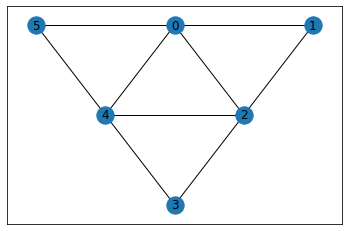

In [26]:
H = nx.Graph([(0,1), (0,2), (0,4), (0,5), (1,2), (2,3), (2,4), (3,4), (4,5)])
nx.draw_networkx(H, pos={0: (0,1), 1: (2,1), 2: (1,-1), 3: (0,-3), 4: (-1,-1), 5: (-2,1)})

Es fácil ver que $H$ tiene las siguientes cliques maximales.

* $Q_1 = \{0,1,2\}$.
* $Q_2 = \{2,3,4\}$.
* $Q_3 = \{0,4,5\}$.
* $Q_4 = \{0,2,4\}$.

Esto también podríamos calcularlo con <code>Networkx</code>:

In [27]:
list(nx.find_cliques(H))

[[0, 2, 1], [0, 2, 4], [0, 5, 4], [3, 2, 4]]

Por lo tanto, $\mathcal Q = \{Q_1, Q_2, Q_3, Q_4\}$.

Sin embargo, el conjunto $\mathcal Q' = \{Q_1, Q_2, Q_3\}$ es un cubrimiento minimal de aristas ya que: (i) para toda arista, existe una clique en $\mathcal Q'$ que contiene a sus extremos, y (ii) si sacamos cualquier clique de $\mathcal Q'$ quedará al menos una arista sin cubrir. 

Como resultado, obtenemos la siguiente formulación, que es más ajustada que (COL), pero menos ajustada que (CLI). 

\begin{align*}
\text{Minimizar:} & \sum_{k \in \mathcal C}w_k \tag{CUB} \\
\text{Sujeto a:} & \sum_{k \in \mathcal C} x_{vk} = 1 & \forall~v \in V. \tag{1}\\
& x_{vk} + x_{uk} \leq w_k & \forall~vu \in E,~  k \in \mathcal C. \tag{2} \\
& \sum_{v \in Q} x_{vk} \leq w_k & \forall~Q \in \mathcal Q',~  k \in \mathcal C. \tag{3} \\
& w_k \in \{0,1\} & \forall~k \in \mathcal C.\\
& x_{vk} \in \{0,1\} & \forall~v \in V,~k \in \mathcal C.
\end{align*}

<b>Observación.</b> Usar un cubrimiento minimal de aristas tiene las siguientes ventajas.
1. Las restricciones (CUB.2) siguen estando implicadas por las (CUB.3). Es decir, podríamos borrarlas y seguiriamos teniendo una formulación del PCG.
2. Las restricciones (CUB.3) tienden a ser bastante diferentes entre sí, es decir, poca intersección de variables.
3. En el peor caso, el número de restricciones (CUB.3) es $|E|.|\mathcal C|$.

Para poder implementar un modelo para (CUB) necesitamos algunas funciones auxiliares. En primer lugar, necesitamos una función que tome una clique y la maximalice. La buena noticia es que ya la definimos en el Notebook 2.

In [28]:
def maximalizar_clique(G, C):
    M = list(C) # Copiar la lista C
    for v in G:
        if v in M:
            continue
        ok = True
        for u in M:
            if not G.has_edge(u,v):
                ok = False
        if ok:
            M.append(v)
    return M

Ahora sí, vamos a definir una función que tome un grafo $G$ y retorne un cubrimiento minimal de sus aristas con cliques. La idea para implementarla es la siguiente. 
1. Inicialmente, ninguna de las aristas de $G$ está cubierta. 
2. Iterativamente, vamos a recorrer una por una sus aristas. 
3. Si una arista $e$ ya fue cubierta, entonces proseguimos con la próxima arista. 
4. De lo contrario, construimos el subgrafo $H$ de $G$ formado por las aristas no cubiertas (esto lo hacemos con la función <code>edge_subgraph</code> de <code>NetworkX</code>).
5. Buscamos una clique maximal <code>clique</code> de $H$ que contenga a los extremos de $e$.
6. Buscamos una clique maximal de $G$ que contenga a <code>clique</code>.
7. Marcamos todas las aristas con extremos en <code>clique</code>como cubiertas.
8. Agregamos <code>clique</code> al cubrimiento y proseguimos con la próxima arista. 

<b>Nota.</b> Si bien podríamos no hacer los pasos 4-5, sino directamente buscar una clique maximal de $G$ que contenga a $e$, decidimos construir $H$ para priorizar las aristas que aun no fueron cubiertas, lo que tiende a reducir el cardinal del cubrimiento.

In [29]:
def cubrir(G):
    cubrimiento = []
    esta_cubierta = {e: False for e in G.edges()}
    for e in G.edges():
        if esta_cubierta[e]:
            continue
        H = nx.edge_subgraph(G, [e2 for e2 in esta_cubierta if not esta_cubierta[e2]])
        clique = maximalizar_clique(H , e)
        clique = maximalizar_clique(G, clique)
        for i, u in enumerate(clique):
            for j, v in enumerate(clique):
                if u < v:
                    esta_cubierta[(u,v)] = True
        cubrimiento.append(clique)
    return cubrimiento

Finalmente, ya podemos definir una función que tome el grafo y el conjunto de colores, y retorne el modelo correspondiente a la formulación (CUB).

In [30]:
def construir_modelo_cub(G, C):
    modelo = construir_modelo_col(G, C)
    modelo.name = "cub"
    X, W = recuperar_variables(G, C, modelo)
    for Q in cubrir(G):
        for k in C:
            modelo.add_constraint(modelo.sum(X[v][k] for v in Q) <= W[k])
    return modelo

### &#x1f4bb; Actividad 3

En esta actividad compararemos las formulaciones (CLI) y (CUB).

1. Genere grafos aleatorios con diferentes densidades (variando el parámetro $p$, probabilidad de arco). ¿Para qué valor de densidad la diferencia entre el número de restricciones de (CLI) y (CUB) es mayor?  
2. Utilizando un par de grafos aleatorios con el valor de $p$ encontrado en el punto anterior, compare la performance de resolver las relajaciones lineales de (CLI) y (CUB). ¿Cuál se resuelve más rápido? ¿Hay variaciones en la cota dual?
3. Vuelva a comparar la performance, esta vez resolviendo los modelos enteros de (CLI) y (CUB). ¿Cuál conviene? ¿Por qué?

<b>Nota.</b> Decida usted un número de vértices interesante, de forma tal que el problema no sea demasiado fácil/difícil de resolver. Proponemos que su resolución demore entre 1 y 5 minutos.